In [2]:
import os
import cv2
import numpy as np

# Paths to the folders
dataset_folder = '/Users/leulnigussieketsela/Downloads/Driver Drowsiness Dataset (DDD)'
drowsy_folder = os.path.join(dataset_folder, 'drowsy')
non_drowsy_folder = os.path.join(dataset_folder, 'non drowsy')

# Function to load images and labels from directories
def load_images_from_folders(drowsy_folder, non_drowsy_folder, img_size):
    images = []
    labels = []
    
    # Load drowsy images
    for img_file in os.listdir(drowsy_folder):
        img_path = os.path.join(drowsy_folder, img_file)
        img = cv2.imread(img_path)
        if img is not None:  # Ensure the image is loaded
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img = cv2.resize(img, img_size)
            img = img.flatten()
            images.append(img)
            labels.append(1)  # Label for drowsy class
    
    # Load non drowsy images
    for img_file in os.listdir(non_drowsy_folder):
        img_path = os.path.join(non_drowsy_folder, img_file)
        img = cv2.imread(img_path)
        if img is not None:  # Ensure the image is loaded
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img = cv2.resize(img, img_size)
            img = img.flatten()
            images.append(img)
            labels.append(0)  # Label for non-drowsy class
    
    return np.array(images), np.array(labels)

# Constants
img_size = (64, 64)  # Resize images to 64x64

# Load images and labels
images, labels = load_images_from_folders(drowsy_folder, non_drowsy_folder, img_size)

# Verify the loaded data
print(f"Loaded {len(images)} images and {len(labels)} labels.")
print(f"Image shape: {images[0].shape}")
print(f"Labels: {np.unique(labels, return_counts=True)}")


Loaded 41793 images and 41793 labels.
Image shape: (4096,)
Labels: (array([0, 1]), array([19445, 22348]))


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create data loaders
def create_data_loader(X, y, batch_size=32):
    tensor_x = torch.Tensor(X)
    tensor_y = torch.LongTensor(y)
    dataset = TensorDataset(tensor_x, tensor_y)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0)

# Split data into training and testing
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.4, random_state=42)
train_loader = create_data_loader(X_train, y_train)
test_loader = create_data_loader(X_test, y_test)


In [4]:
# Define the model
class ImprovedNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(ImprovedNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(256, 128)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(128, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        return out

# Prepare model, optimizer and tasks
input_size = 64 * 64
num_classes = 2
model = ImprovedNN(input_size, num_classes).to(device)
meta_optimizer = optim.Adam(model.parameters(), lr=0.001)


In [5]:
# Create tasks for MAML 
def create_tasks(X, y, num_tasks=10, task_split=0.5):
    tasks = []
    for _ in range(num_tasks):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=task_split)
        train_loader = create_data_loader(X_train, y_train)
        test_loader = create_data_loader(X_test, y_test)
        tasks.append((train_loader, test_loader))
    return tasks

# Create tasks for MAML
tasks = create_tasks(images, labels)


In [6]:
# Evaluate model function
def evaluate_model(model, tasks):
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for train_loader, test_loader in tasks:
            for x, y in test_loader:
                x, y = x.to(device), y.to(device)
                preds = model(x)
                loss = nn.CrossEntropyLoss()(preds, y)
                val_loss += loss.item()
                correct += (preds.argmax(dim=1) == y).sum().item()
                total += y.size(0)
    model.train()
    return val_loss / len(tasks), correct / total


Iteration 1/305, Task 1/10
Iteration 1/305, Task 2/10
Iteration 1/305, Task 3/10
Iteration 1/305, Task 4/10
Iteration 1/305, Task 5/10
Iteration 1/305, Task 6/10
Iteration 1/305, Task 7/10
Iteration 1/305, Task 8/10
Iteration 1/305, Task 9/10
Iteration 1/305, Task 10/10
Iteration 2/305, Task 1/10
Iteration 2/305, Task 2/10
Iteration 2/305, Task 3/10
Iteration 2/305, Task 4/10
Iteration 2/305, Task 5/10
Iteration 2/305, Task 6/10
Iteration 2/305, Task 7/10
Iteration 2/305, Task 8/10
Iteration 2/305, Task 9/10
Iteration 2/305, Task 10/10
Iteration 3/305, Task 1/10
Iteration 3/305, Task 2/10
Iteration 3/305, Task 3/10
Iteration 3/305, Task 4/10
Iteration 3/305, Task 5/10
Iteration 3/305, Task 6/10
Iteration 3/305, Task 7/10
Iteration 3/305, Task 8/10
Iteration 3/305, Task 9/10
Iteration 3/305, Task 10/10
Iteration 4/305, Task 1/10
Iteration 4/305, Task 2/10
Iteration 4/305, Task 3/10
Iteration 4/305, Task 4/10
Iteration 4/305, Task 5/10
Iteration 4/305, Task 6/10
Iteration 4/305, Task 7/1

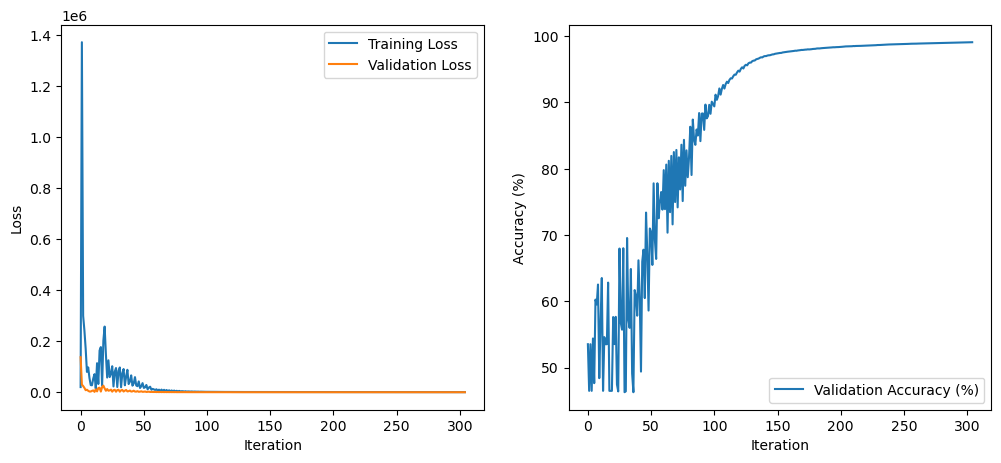

In [7]:
# MAML training function
def maml_train(model, meta_optimizer, tasks, num_iterations=305, num_inner_steps=5, inner_lr=0.01):
    train_losses = []
    val_losses = []
    val_accuracies = []
    
    for iteration in range(num_iterations):
        meta_optimizer.zero_grad()
        
        meta_loss = 0
        for i, (train_loader, test_loader) in enumerate(tasks):
            print(f"Iteration {iteration+1}/{num_iterations}, Task {i+1}/{len(tasks)}")

            fast_weights = [w.clone() for w in model.parameters()]
            
            for step in range(num_inner_steps):
                for x, y in train_loader:
                    x, y = x.to(device), y.to(device)
                    preds = model(x)
                    loss = nn.CrossEntropyLoss()(preds, y)
                    grads = torch.autograd.grad(loss, fast_weights, create_graph=True, allow_unused=True)
                    fast_weights = [w - inner_lr * g if g is not None else w for w, g in zip(fast_weights, grads)]
            
            for x, y in test_loader:
                x, y = x.to(device), y.to(device)
                preds = model(x)
                loss = nn.CrossEntropyLoss()(preds, y)
                meta_loss += loss
        
        meta_loss.backward()
        meta_optimizer.step()

        # Logging training loss
        train_losses.append(meta_loss.item())
        
        # Validation
        val_loss, val_acc = evaluate_model(model, tasks)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

    # Plot training and validation loss
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.legend()

    # Plot validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot([acc * 100 for acc in val_accuracies], label='Validation Accuracy (%)')
    plt.xlabel('Iteration')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.show()

# Train the model using MAML 
maml_train(model, meta_optimizer, tasks)


              precision    recall  f1-score   support

       awake       0.99      0.99      0.99      7735
      drowsy       0.99      0.99      0.99      8983

    accuracy                           0.99     16718
   macro avg       0.99      0.99      0.99     16718
weighted avg       0.99      0.99      0.99     16718



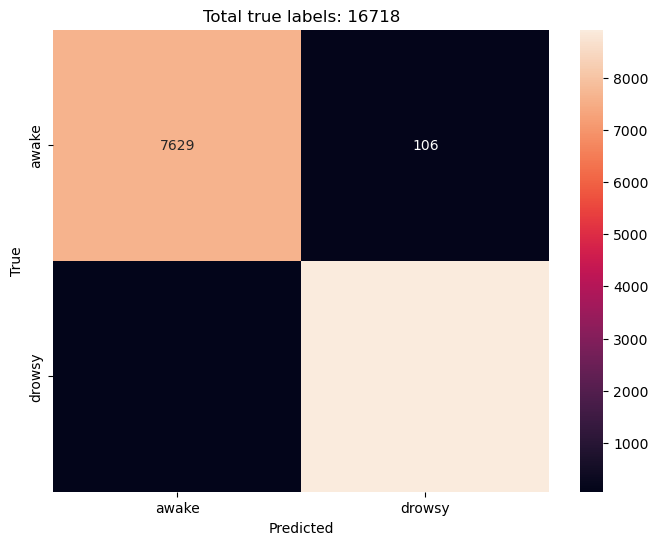

Accuracy: 99.00%
Total labels of each class: {'awake': 7735, 'drowsy': 8983}


In [8]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Function to adapt and evaluate
def adapt_and_evaluate(model, train_loader, test_loader, num_inner_steps=5, inner_lr=0.01):
    fast_weights = [w.clone() for w in model.parameters()]
    for step in range(num_inner_steps):
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            preds = model(x)
            loss = nn.CrossEntropyLoss()(preds, y)
            grads = torch.autograd.grad(loss, fast_weights, allow_unused=True)
            fast_weights = [w - inner_lr * g if g is not None else w for w, g in zip(fast_weights, grads)]
    
    all_preds = []
    all_labels = []
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        preds = model(x)
        all_preds.extend(preds.argmax(dim=1).cpu().numpy())
        all_labels.extend(y.cpu().numpy())
    
    print(classification_report(all_labels, all_preds, target_names=['awake', 'drowsy']))
    
    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=['awake', 'drowsy'], yticklabels=['awake', 'drowsy'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Total true labels: {sum(cm.flatten())}')
    plt.show()

    # Print accuracy
    accuracy = (np.trace(cm) / float(np.sum(cm))) * 100
    print(f'Accuracy: {accuracy:.2f}%')

    # Print total labels of each class
    total_labels = dict(zip(['awake', 'drowsy'], np.sum(cm, axis=1)))
    print(f'Total labels of each class: {total_labels}')

# Evaluate and display predictions
adapt_and_evaluate(model, train_loader, test_loader)


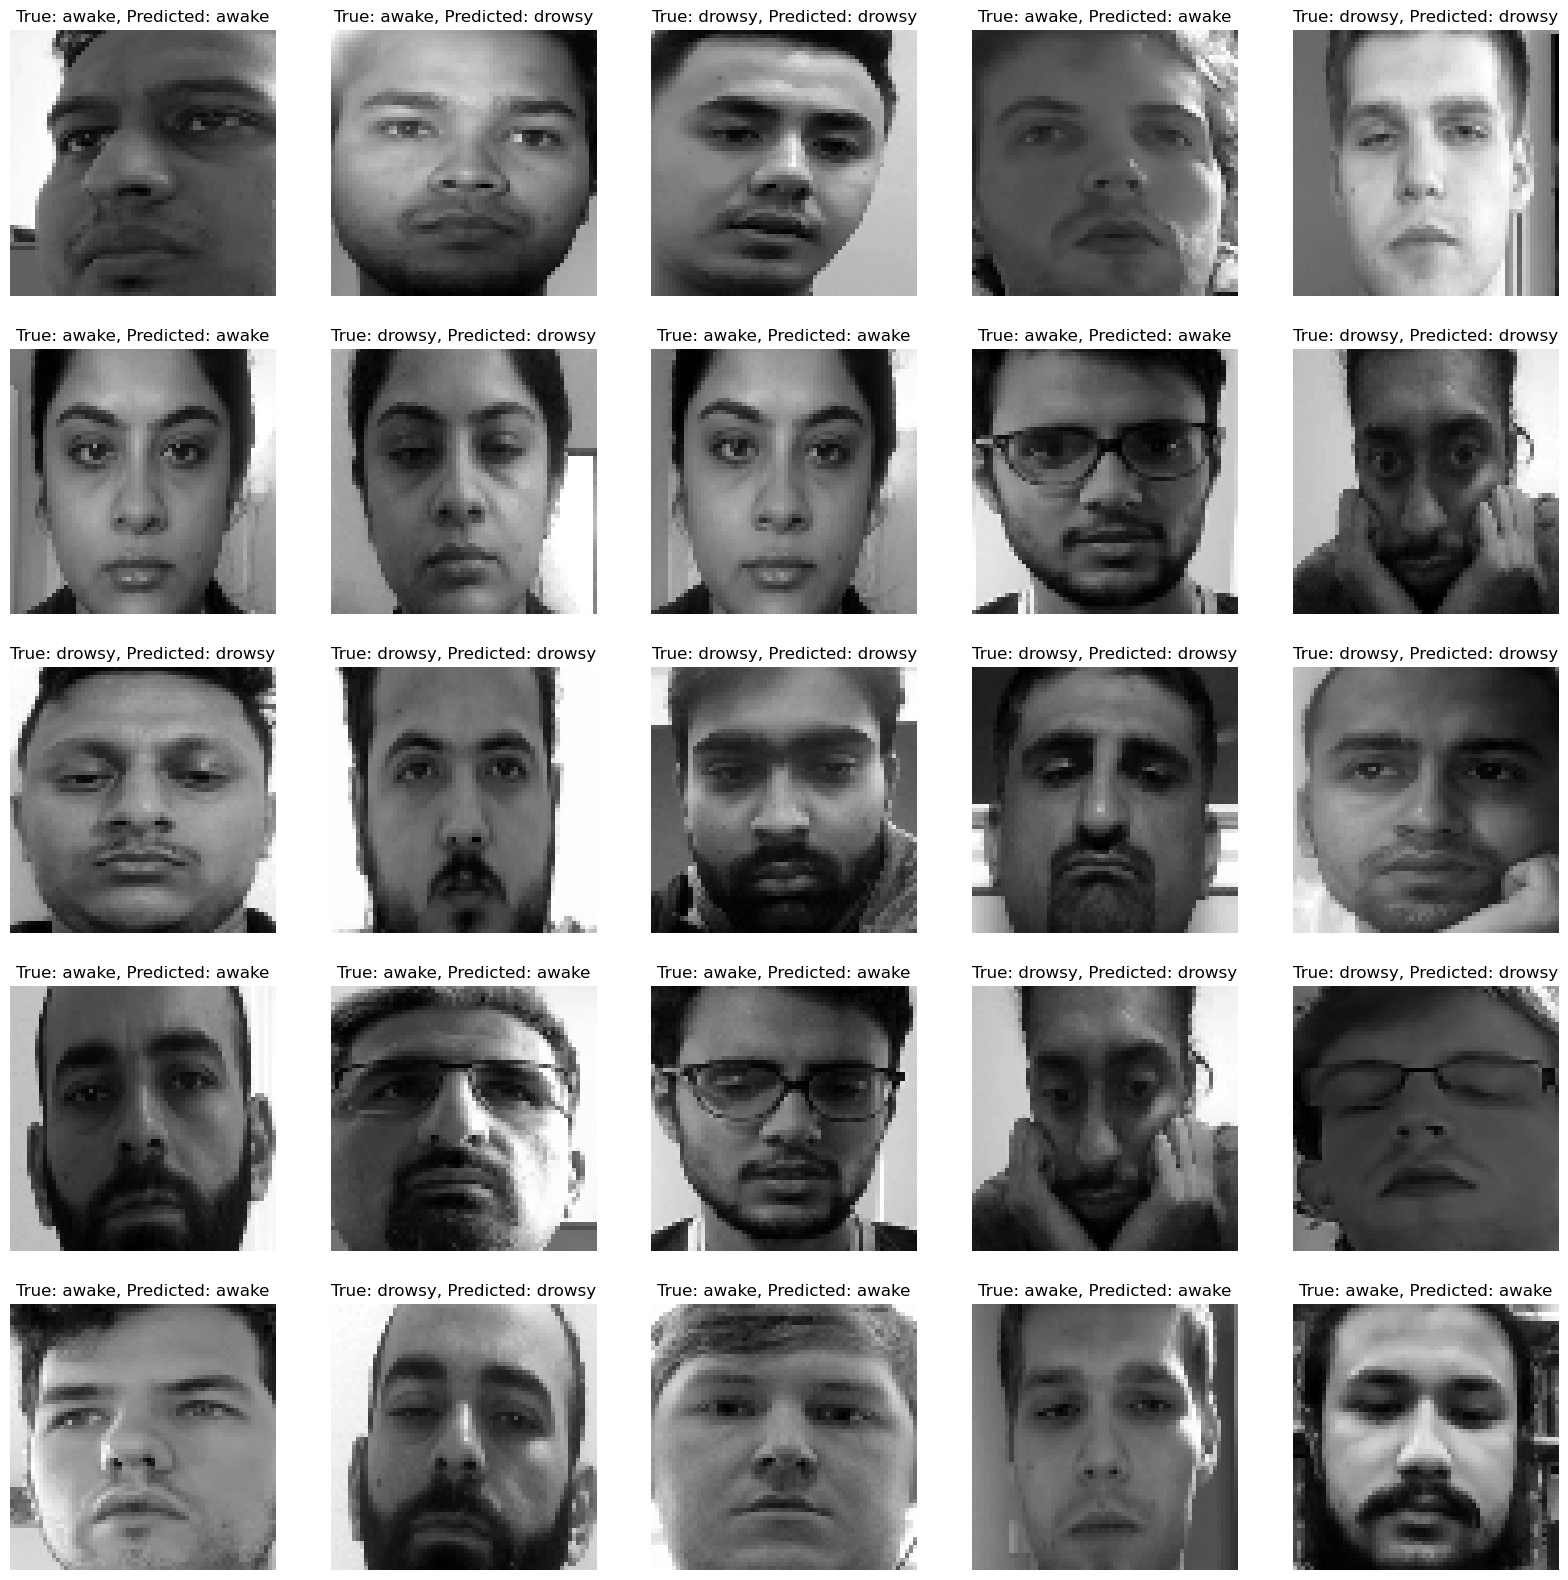

In [9]:
import matplotlib.pyplot as plt


def show_class_specific_predictions(model, test_loader):
    model.eval()
    fig, axs = plt.subplots(5, 5, figsize=(20, 20))
    axs = axs.flatten()
    
    class_names = ['awake', 'drowsy']
    class_counts = {'awake': 12, 'drowsy': 13}
    displayed_counts = {'awake': 0, 'drowsy': 0}
    
    with torch.no_grad():
        for x, y in test_loader:
            for i in range(len(x)):
                img, true_label = x[i].unsqueeze(0).to(device), y[i].item()
                preds = model(img)
                predicted_label = preds.argmax(dim=1).item()
                class_name = class_names[predicted_label]
                
                if displayed_counts[class_name] < class_counts[class_name]:
                    # Convert the image to numpy array for display
                    img = img.cpu().numpy().reshape(64, 64)
                    
                    # Display the image
                    axs_idx = sum(displayed_counts.values())
                    if axs_idx >= len(axs):
                        break
                    axs[axs_idx].imshow(img, cmap='gray')
                    axs[axs_idx].set_title(f"True: {class_names[true_label]}, Predicted: {class_name}")
                    axs[axs_idx].axis('off')
                    
                    displayed_counts[class_name] += 1
                    
                    if sum(displayed_counts.values()) == 30:
                        plt.tight_layout()
                        plt.show()
                        return

# Show class-specific predictions
show_class_specific_predictions(model, test_loader)
